In [208]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [209]:
class AccelDataset(Dataset):
    def __init__(self, data, labels, sequence_length=10):
        self.data = [data[i:i+sequence_length] for i in range(len(data) - sequence_length + 1)]
        self.labels = labels[(int)(sequence_length/2) - 1 : len(data) - (sequence_length - (int)(sequence_length/2))]
        # change to get the majority
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx].transpose(0, 1), self.labels[idx]  # Transposing the sequence and channel dimensions


In [225]:
# Load CSV file
WORKAREA_PATH = './'
class_num = 16 ## Although annoying, requiring this be manually adjusted
    ## to open the file also means that a later instance of this number will be correct
dataframe = pd.read_csv(WORKAREA_PATH + f'Data/COMBINED_Type3-Freq10-Labeled_Motion-sessions_23-24_Fall.csv')
# code test file: Data/Week 1/Left then Right/Processed/Type3-Freq10-Labeled_Motion-sessions_2023-08-26_17-25-54.csv
# classifier training file: Data/COMBINED_Type3-Freq10-Labeled_Motion-sessions_23-24_Fall.csv
# LIST OF FULL-SIZED FILES:
    # Data/COMBINED_Type3-Freq10-Labeled_Motion-sessions_23-24_Fall.csv
    # Data/COMBINED_Type5-WithClassNum{class_num}-Freq10-Labeled_Motion-sessions_23-24_Fall.csv

# print(len(dataframe))
# print()
# print(dataframe.columns)
dataframe.columns = pd.Index(np.arange(len(dataframe.columns)), dtype='int64')
# print(dataframe.columns)
resize_data_counts = False
remove_statoth = False
if resize_data_counts:
    def skcounter(df):
        skarr = np.unique(df, return_counts = True)
        # print(skarr)
        # find_index = np.where(skarr[0], True, False)
        # for i in range(len(find_index)):
        #     if find_index[i]: ret_valsk = skarr[1][i]
        ret_dict = dict(zip(skarr[0], skarr[1]))
        print(ret_dict)
        ret_valsk = ret_dict.get(1, 0)
        print(ret_valsk)
        # print(dataframe)
        return ret_valsk
    avg_count = int(np.median(dataframe[dataframe.columns[3 : ]].apply(lambda x: skcounter(x)).to_numpy()))
    # class_counts = {}
    # for i in dataframe.columns[input_num : ]:
    #     if i == SKDescriptors.STATIONARY_CLASS:
    #         stationary_rows = dataframe[dataframe[i] == 1]
    #         continue
    #     class_counts[i] = len(dataframe[dataframe[i] == 1])

    print()
    for i in dataframe.columns[3 : ]:
        class_i_rows = dataframe[dataframe[i] == 1]
        # this is the line doing the actual randomization
        sample_rows = class_i_rows.sample(min(len(class_i_rows), avg_count), random_state=42)
        print(len(sample_rows))
        dataframe = dataframe.drop(class_i_rows.drop(sample_rows.index).index)
        print(len(dataframe))
if remove_statoth:
    dataframe = dataframe.drop(pd.concat([dataframe[dataframe[len(dataframe.columns) - 2] == 1], dataframe[dataframe[len(dataframe.columns) - 1] == 1]]).index)



# Get data and labels from dataframe
data = dataframe.iloc[:, :3].values  # x, y, z data
labels = dataframe.iloc[:, 3:].values  # labels


sequence_length = 10

# Split data into training and test sets
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert data to tensors
data_train = torch.tensor(data_train, dtype=torch.float32)  
data_test = torch.tensor(data_test, dtype=torch.float32)

# Convert labels to tensors and get max index (assuming one-hot encoding)
labels_train = torch.argmax(torch.tensor(labels_train, dtype=torch.float32), dim=1)
labels_test = torch.argmax(torch.tensor(labels_test, dtype=torch.float32), dim=1)

# Create data loaders
train_dataset = AccelDataset(data_train, labels_train, sequence_length)
test_dataset = AccelDataset(data_test, labels_test, sequence_length)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


{0: 21769, 1: 523}
523
{0: 21771, 1: 521}
521
{0: 21799, 1: 493}
493
{0: 21765, 1: 527}
527
{0: 21864, 1: 428}
428
{0: 21874, 1: 418}
418
{0: 21957, 1: 335}
335
{0: 21904, 1: 388}
388
{0: 21480, 1: 812}
812
{0: 21558, 1: 734}
734
{0: 21863, 1: 429}
429
{0: 21890, 1: 402}
402
{0: 22006, 1: 286}
286
{0: 22022, 1: 270}
270
{0: 8990, 1: 13302}
13302
{0: 19869, 1: 2423}
2423

461
22230
461
22170
461
22138
461
22072
428
22072
418
22072
335
22072
388
22072
461
21721
461
21448
429
21448
402
21448
286
21448
270
21448
461
8607
461
6645


In [226]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv1d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3)
        
        # Adjust the fully connected layer's input size based on the new sequence length after convolutions.
        # Adjusted for sequence length = 4 after 3 conv layers with kernel size 3
        # 10 -3 + 1 = 8 after the first layer
        # 8 - 3 + 1 = 6 after the second layer
        # 6 - 3 + 1 = 4 after the third layer
        self.fc1 = nn.Linear(256 * (sequence_length - 6), 128)  # Adjusted for sequence length = 4 after 3 conv layers with kernel size 3
        self.fc2 = nn.Linear(128, class_num)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Apply softmax to the output layer

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [227]:


 

# Loading the model later

model = torch.load('model-5_29_2024-AdjustStatANDOtherToAdjMean_Type3.pth')

model.eval()  # Set the model to evaluation mode

Net(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
)

In [228]:
all_preds = []

all_labels = []


correct = 0
total = 0


with torch.no_grad():   # Since we're not training, we don't need to calculate the gradients

    for data in test_dataloader:

        inputs, labels = data

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

Accuracy of the network on the test data: 20 %


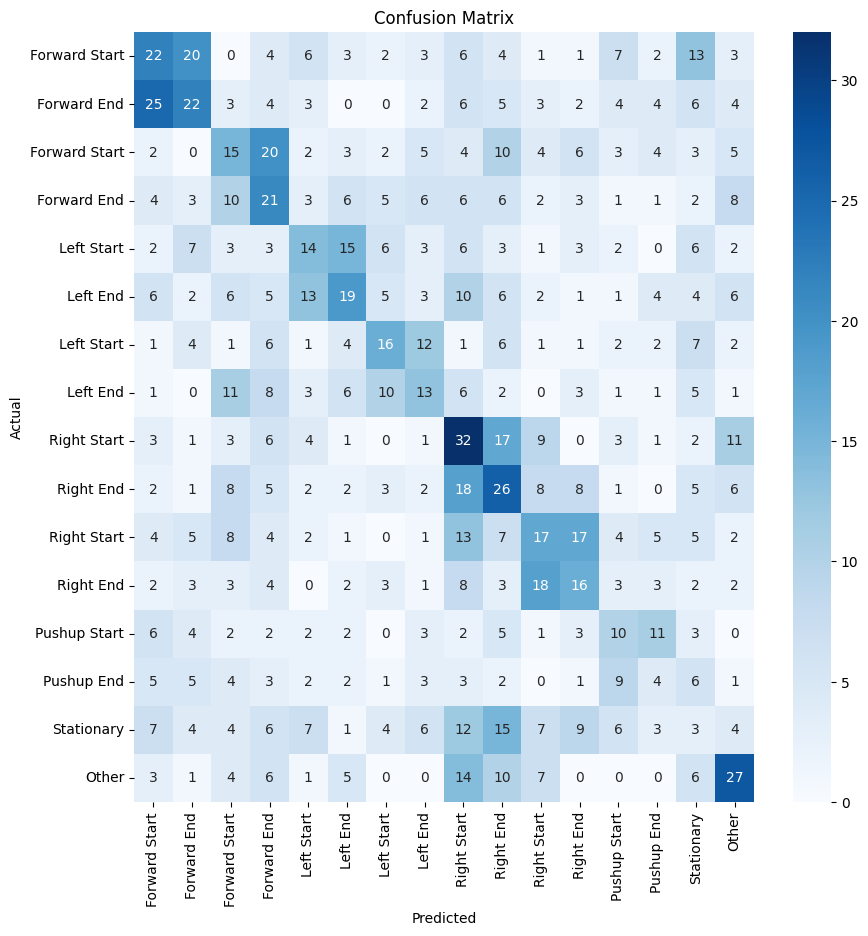

In [229]:
cm = confusion_matrix(all_labels, all_preds)

 

def plot_confusion_matrix(cm, class_names):

    fig, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.title('Confusion Matrix')

    plt.show()

 

# Replace 'class_names' with your actual class names

class_names = ['Forward Start', 'Forward End', 'Forward Start', 'Forward End', 'Left Start', 'Left End', 'Left Start', 'Left End', 'Right Start', 'Right End', 'Right Start', 'Right End', 'Pushup Start', 'Pushup End', 'Stationary', 'Other']
# class_names = ['Forward Start', 'Forward End', 'Lateral Start', 'Lateral End', 'Pushup Start', 'Pushup End', 'Stationary', 'Other']


plot_confusion_matrix(cm, class_names)